# Prediction Latency
- 다양한 사이킷 런 추정기를 사용하여 레이턴시를 측정한다.

In [1]:
import gc
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.utils import shuffle


def _not_in_sphinx():
    # 현재 Sphinx 빌더로 실행 중인지 여부를 감지하는 해킹 방법을 알려준다.
    return "__file__" in globals()

## Benchmark and plot helper functions

In [2]:
def atomic_benchmark_estimator(estimator, X_test, verbose=False):
    """각 인스턴스에서 실행 시간은 측정하고 예측한다."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_instances, dtype=float)
    for i in range(n_instances):
        instance = X_test[[i], :]
        start = time.time()
        estimator.predict(instance)
        runtimes[i] = time.time() - start
    if verbose:
        print(
            "atomic_benchmark runtimes:",
            min(runtimes),
            np.percentile(runtimes, 50),
            max(runtimes),
        )
    return runtimes

In [3]:
def bulk_benchmark_estimator(estimator, X_test, n_bulk_repeats, verbose):
    """모든 입력값에서 실행 시간은 측정하고 예측한다."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_bulk_repeats, dtype=float)
    for i in range(n_bulk_repeats):
        start = time.time()
        estimator.predict(X_test)
        runtimes[i] = time.time() - start
    runtimes = np.array(list(map(lambda x: x / float(n_instances), runtimes)))
    if verbose:
        print(
            "bulk_benchmark runtimes:",
            min(runtimes),
            np.percentile(runtimes, 50),
            max(runtimes),
        )
    return runtimes


In [4]:
def benchmark_estimator(estimator, X_test, n_bulk_repeats=30, verbose=False):
    """
    예측 실행 시간을 원자적 모드와 일괄 처리 모드로 측정한다.

    Parameters
    ----------
    estimator : 이미 학습된 `predict()`를 지원하는 추정기
    X_test : 테스트 입력
    n_bulk_repeats : 일괄 처리 모드를 평가할 때 반복 횟수

    Returns
    -------
    atomic_runtimes, bulk_runtimes : 초 단위의 실행 시간을 포함하는 `np.array` 쌓인다.

    """
    atomic_runtimes = atomic_benchmark_estimator(estimator, X_test, verbose)
    bulk_runtimes = bulk_benchmark_estimator(estimator, X_test, n_bulk_repeats, verbose)
    return atomic_runtimes, bulk_runtimes

In [5]:
def generate_dataset(n_train, n_test, n_features, noise=0.1, verbose=False):
    """주어진 매개변수로 회귀 데이터셋을 생성한다"""
    if verbose:
        print("generating dataset...")

    X, y, coef = make_regression(
        n_samples=n_train + n_test, n_features=n_features, noise=noise, coef=True
    )

    random_seed = 13
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_train, test_size=n_test, random_state=random_seed
    )
    X_train, y_train = shuffle(X_train, y_train, random_state=random_seed)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
    y_test = y_scaler.transform(y_test[:, None])[:, 0]

    gc.collect()
    if verbose:
        print("ok")
    return X_train, y_train, X_test, y_test

In [6]:
def boxplot_runtimes(runtimes, pred_type, configuration):
    """
    Plot a new `Figure` with boxplots of prediction runtimes.

    Parameters
    ----------
    runtimes : 마이크로초 단위의 지연 시간 리스트인 `np.array`의 목록
    cls_names : 실행 시간을 생성한 추정기 클래 이름의 목록
    pred_type : 'bulk' 또는 'atomic' 중 하나

    """

    fig, ax1 = plt.subplots(figsize=(10, 6))
    bp = plt.boxplot(
        runtimes,
    )

    cls_infos = [
        "%s\n(%d %s)"
        % (
            estimator_conf["name"],
            estimator_conf["complexity_computer"](estimator_conf["instance"]),
            estimator_conf["complexity_label"],
        )
        for estimator_conf in configuration["estimators"]
    ]
    plt.setp(ax1, xticklabels=cls_infos)
    plt.setp(bp["boxes"], color="black")
    plt.setp(bp["whiskers"], color="black")
    plt.setp(bp["fliers"], color="red", marker="+")

    ax1.yaxis.grid(True, linestyle="-", which="major", color="lightgrey", alpha=0.5)

    ax1.set_axisbelow(True)
    ax1.set_title(
        "Prediction Time per Instance - %s, %d feats."
        % (pred_type.capitalize(), configuration["n_features"])
    )
    ax1.set_ylabel("Prediction Time (us)")

    plt.show()

In [7]:
def benchmark(configuration):
    """전체 벤치마크를 실행한다."""
    X_train, y_train, X_test, y_test = generate_dataset(
        configuration["n_train"], configuration["n_test"], configuration["n_features"]
    )

    stats = {}
    for estimator_conf in configuration["estimators"]:
        print("Benchmarking", estimator_conf["instance"])
        estimator_conf["instance"].fit(X_train, y_train)
        gc.collect()
        a, b = benchmark_estimator(estimator_conf["instance"], X_test)
        stats[estimator_conf["name"]] = {"atomic": a, "bulk": b}

    cls_names = [
        estimator_conf["name"] for estimator_conf in configuration["estimators"]
    ]
    runtimes = [1e6 * stats[clf_name]["atomic"] for clf_name in cls_names]
    boxplot_runtimes(runtimes, "atomic", configuration)
    runtimes = [1e6 * stats[clf_name]["bulk"] for clf_name in cls_names]
    boxplot_runtimes(runtimes, "bulk (%d)" % configuration["n_test"], configuration)

In [8]:
def n_feature_influence(estimators, n_train, n_test, n_features, percentile):
    """
    특성의 개수가 예측 시간에 미치는 영향을 추정

    Parameters
    ----------

    estimators : 성능 평가를 위한 (name (str), estimator)로 구성된 딕셔너리 
    n_train : 훈련 인스턴스의 개수 (int)
    n_test : 테스트 인스턴스의 개수 (int)
    n_features : 테스트할 특성 공간의 차원 리스트 (int)
    percentile : 속도를 측정할 백분위 수 (int [0-100])

    Returns:
    --------

    percentiles : dict(estimator_name,
                       dict(n_features, percentile_perf_in_us))

    """
    percentiles = defaultdict(defaultdict)
    for n in n_features:
        print("benchmarking with %d features" % n)
        X_train, y_train, X_test, y_test = generate_dataset(n_train, n_test, n)
        for cls_name, estimator in estimators.items():
            estimator.fit(X_train, y_train)
            gc.collect()
            runtimes = bulk_benchmark_estimator(estimator, X_test, 30, False)
            percentiles[cls_name][n] = 1e6 * np.percentile(runtimes, percentile)
    return percentiles

In [9]:
def plot_n_features_influence(percentiles, percentile):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    colors = ["r", "g", "b"]
    for i, cls_name in enumerate(percentiles.keys()):
        x = np.array(sorted(percentiles[cls_name].keys()))
        y = np.array([percentiles[cls_name][n] for n in x])
        plt.plot(
            x,
            y,
            color=colors[i],
        )
    ax1.yaxis.grid(True, linestyle="-", which="major", color="lightgrey", alpha=0.5)
    ax1.set_axisbelow(True)
    ax1.set_title("Evolution of Prediction Time with #Features")
    ax1.set_xlabel("#Features")
    ax1.set_ylabel("Prediction Time at %d%%-ile (us)" % percentile)
    plt.show()

In [10]:
def benchmark_throughputs(configuration, duration_secs=0.1):
    """다른 추정기에 대한 성능 평가 처리량을 측정한다."""
    X_train, y_train, X_test, y_test = generate_dataset(
        configuration["n_train"], configuration["n_test"], configuration["n_features"]
    )
    throughputs = dict()
    for estimator_config in configuration["estimators"]:
        estimator_config["instance"].fit(X_train, y_train)
        start_time = time.time()
        n_predictions = 0
        while (time.time() - start_time) < duration_secs:
            estimator_config["instance"].predict(X_test[[0]])
            n_predictions += 1
        throughputs[estimator_config["name"]] = n_predictions / duration_secs
    return throughputs

In [11]:
def plot_benchmark_throughput(throughputs, configuration):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ["r", "g", "b"]
    cls_infos = [
        "%s\n(%d %s)"
        % (
            estimator_conf["name"],
            estimator_conf["complexity_computer"](estimator_conf["instance"]),
            estimator_conf["complexity_label"],
        )
        for estimator_conf in configuration["estimators"]
    ]
    cls_values = [
        throughputs[estimator_conf["name"]]
        for estimator_conf in configuration["estimators"]
    ]
    plt.bar(range(len(throughputs)), cls_values, width=0.5, color=colors)
    ax.set_xticks(np.linspace(0.25, len(throughputs) - 0.75, len(throughputs)))
    ax.set_xticklabels(cls_infos, fontsize=10)
    ymax = max(cls_values) * 1.2
    ax.set_ylim((0, ymax))
    ax.set_ylabel("Throughput (predictions/sec)")
    ax.set_title(
        "Prediction Throughput for different estimators (%d features)"
        % configuration["n_features"]
    )
    plt.show()

## Bechmark bulk/atomic prediction speed form various regressor

Benchmarking SGDRegressor(alpha=0.01, l1_ratio=0.25, penalty='elasticnet', tol=0.0001)
Benchmarking RandomForestRegressor()
Benchmarking SVR()


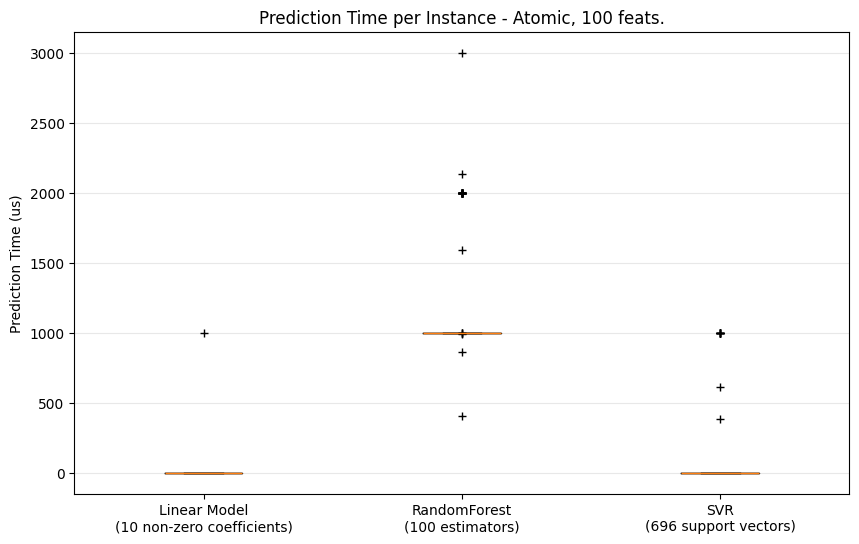

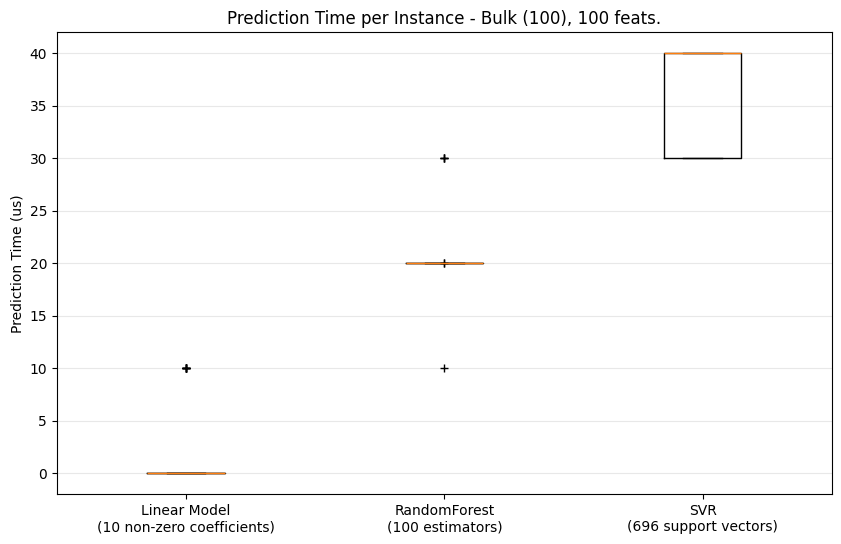

In [12]:
configuration = {
    "n_train": int(1e3),
    "n_test": int(1e2),
    "n_features": int(1e2),
    "estimators": [
        {
            "name": "Linear Model",
            "instance": SGDRegressor(
                penalty="elasticnet", alpha=0.01, l1_ratio=0.25, tol=1e-4
            ),
            "complexity_label": "non-zero coefficients",
            "complexity_computer": lambda clf: np.count_nonzero(clf.coef_),
        },
        {
            "name": "RandomForest",
            "instance": RandomForestRegressor(),
            "complexity_label": "estimators",
            "complexity_computer": lambda clf: clf.n_estimators,
        },
        {
            "name": "SVR",
            "instance": SVR(kernel="rbf"),
            "complexity_label": "support vectors",
            "complexity_computer": lambda clf: len(clf.support_vectors_),
        },
    ],
}
benchmark(configuration)

## Benchmark n_features influence on prediction speed

benchmarking with 100 features
benchmarking with 250 features
benchmarking with 500 features


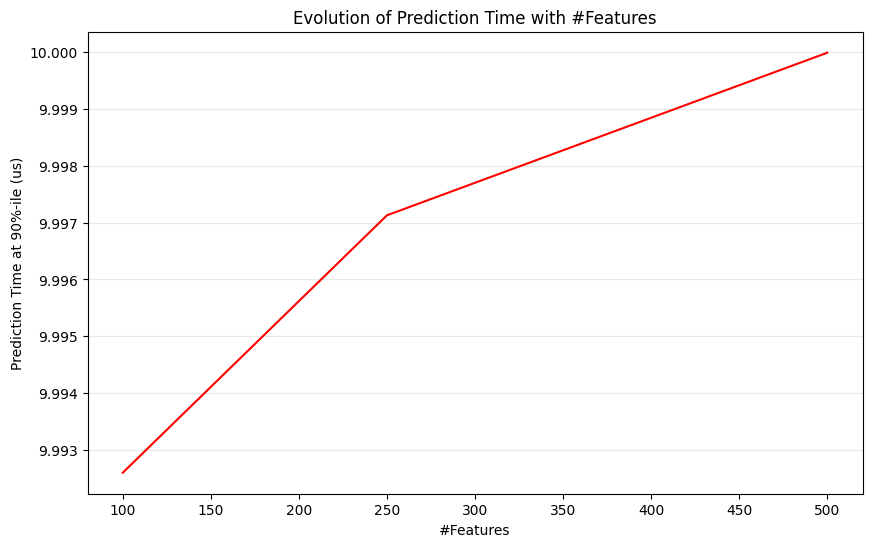

In [13]:
percentile = 90
percentiles = n_feature_influence(
    {"ridge": Ridge()},
    configuration["n_train"],
    configuration["n_test"],
    [100, 250, 500],
    percentile,
)
plot_n_features_influence(percentiles, percentile)

## Benchmark throughput

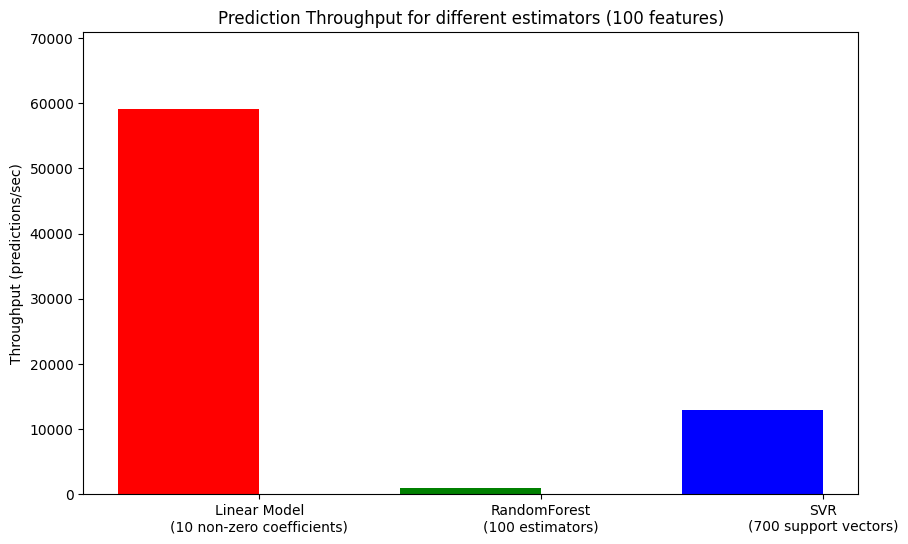

In [14]:
throughputs = benchmark_throughputs(configuration)
plot_benchmark_throughput(throughputs, configuration)